# 전력사용하여 예측

In [18]:
#http://mjgim.me/2017/08/02/LSTM.html

#라이브러리 불러오기
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [19]:
#데이터 불러오기
jan = pd.read_csv(r"C:/Users/jmlee/Desktop/4학년 2학기/딥러닝 전력 예측/전력 예측/생성data/1월.csv", header=None)
july = pd.read_csv(r"C:/Users/jmlee/Desktop/4학년 2학기/딥러닝 전력 예측/전력 예측/생성data/7월.csv", header=None)
jan_=jan.loc[:,[1,2,4]][1:]
# july_=july.loc[:,[1,2,4]][1:]

In [3]:
# All=pd.concat([jan_,july_])
#str을 float로 바꾸기
jan_.columns=['월','일','전력량']
jan_[['월','일','전력량']]=jan_[['월','일','전력량']].apply(pd.to_numeric)

In [4]:
jan_

,월,일,전력량
1,1,1,238.32
2,1,1,236.16
3,1,1,237.24
4,1,1,236.16
5,1,1,234.72
...,...,...,...
2876,1,30,340.20
2877,1,30,294.12
2878,1,30,263.88
2879,1,30,261.00


In [5]:
def MinMaxScaler(data):
    numerator=data-np.min(data,0)
    denominator=np.max(data,0)-np.min(data,0)
    return numerator/(denominator+1e-7)

In [6]:
#하이퍼 파라미터 설정
timesteps = seq_length = 7  #한개의 시퀀스길이(시계열데이터 입력갯수)
data_dim = 3  #variable개수
hidden_dim = 10  #각셀의 출력크기
output_dim = 1  #결과분류 총 수
learing_rate = 0.001   #학습률
iterations = 50_000   #에폭횟수

In [7]:
# #데이터 조절
# jan_["전력량"] /= 1e5

#Framework 제작
jan_['전력량']=MinMaxScaler(jan_['전력량'])
x = jan_[['월','일','전력량']].values
y = jan_["전력량"].values  

In [8]:
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):  #seq_length=timesteps=6
    _x = np.copy(x[i:i + seq_length + 1])
#     _x[timesteps-2][data_dim-1] = 0
#     _x[timesteps-1][data_dim-1] = 0
#     _x[timesteps][data_dim-1] = 0
    _y = [y[i + seq_length]] #다음 전력(정답)
    dataX.append(_x)
    dataY.append(_y)

In [9]:
dataX

[array([[1.        , 1.        , 0.24716553],
        [1.        , 1.        , 0.24263039],
        [1.        , 1.        , 0.24489796],
        [1.        , 1.        , 0.24263039],
        [1.        , 1.        , 0.23960695],
        [1.        , 1.        , 0.23507181],
        [1.        , 1.        , 0.23507181],
        [1.        , 1.        , 0.2441421 ]]),
 array([[1.        , 1.        , 0.24263039],
        [1.        , 1.        , 0.24489796],
        [1.        , 1.        , 0.24263039],
        [1.        , 1.        , 0.23960695],
        [1.        , 1.        , 0.23507181],
        [1.        , 1.        , 0.23507181],
        [1.        , 1.        , 0.2441421 ],
        [1.        , 1.        , 0.24263039]]),
 array([[1.        , 1.        , 0.24489796],
        [1.        , 1.        , 0.24263039],
        [1.        , 1.        , 0.23960695],
        [1.        , 1.        , 0.23507181],
        [1.        , 1.        , 0.23507181],
        [1.        , 1.       

In [10]:
dataY

[[0.24414210123369823],
 [0.24263038543658555],
 [0.24263038543658555],
 [0.2396069538423602],
 [0.24187452753802924],
 [0.24414210123369823],
 [0.24111866963947287],
 [0.23809523804524751],
 [0.24338624333514192],
 [0.2448979591322546],
 [0.24111866963947287],
 [0.24036281174091656],
 [0.24111866963947287],
 [0.24187452753802924],
 [0.24338624333514192],
 [0.24414210123369823],
 [0.2456538170308109],
 [0.24867724862503626],
 [0.25018896442214894],
 [0.24867724862503626],
 [0.24867724862503626],
 [0.2585034013062687],
 [0.2600151171033814],
 [0.26152683290049406],
 [0.2668178381903885],
 [0.32653061217633944],
 [0.318972033190776],
 [0.2804232803644026],
 [0.2456538170308109],
 [0.26606198029183215],
 [0.25018896442214894],
 [0.16780045347950778],
 [0.2025699168130995],
 [0.18745275884197263],
 [0.15721844289971898],
 [0.13983371123292312],
 [0.12396069536323995],
 [0.10279667420366242],
 [0.09750566891376802],
 [0.08994708992820462],
 [0.09599395311665533],
 [0.09977324260943707],
 [0

In [11]:
#학습데이터와 테스트데이터 분류

train_size = int(len(dataY) * 0.8)
test_size = len(dataY) - train_size 

trainX = np.array(dataX[:train_size])  #2298
testX = np.array(dataX[train_size : ])

trainY = np.array(dataY[:train_size])  #575
testY = np.array(dataY[train_size : ])

In [12]:
#LSTM모델 구축
#placeholder 초기화 후 텐서에 매핑
X = tf.placeholder(tf.float32, [None, seq_length+1, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

def lstm_cell(): #cell생성
    cell = tf.nn.rnn_cell.LSTMCell(hidden_dim, reuse=tf.AUTO_REUSE)  #출력의 크기를 hidden dim=4
    return cell 
## 5 layers for hidden layer
multi_cells = rnn.MultiRNNCell([lstm_cell() for _ in range(5)], state_is_tuple=True)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [13]:
# dynamic rnn 구조(RNN 신경망)연결
outputs, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32) #결과값 output차원은 hidden_dim의 크기와 동일

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [14]:
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)
loss = tf.reduce_sum(tf.square(Y_pred - Y)) 

In [15]:
#RMSprop 알고리즘
train = tf.train.RMSPropOptimizer(learing_rate).minimize(loss)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [16]:
for i in range(iterations):
    _  , cost = sess.run([train ,loss], feed_dict={X: trainX, Y: trainY})
    if (i+1) % (iterations/1000) == 0:
        print("[step: {}] loss: {}".format(i+1, cost))

[step: 50] loss: 121.96672058105469
[step: 100] loss: 114.59514617919922
[step: 150] loss: 53.209922790527344
[step: 200] loss: 35.66069412231445
[step: 250] loss: 31.91179084777832
[step: 300] loss: 30.55862045288086
[step: 350] loss: 29.78300666809082
[step: 400] loss: 29.15056037902832
[step: 450] loss: 28.57026481628418
[step: 500] loss: 28.014240264892578
[step: 550] loss: 27.45524787902832
[step: 600] loss: 26.874536514282227
[step: 650] loss: 26.242813110351562
[step: 700] loss: 25.535282135009766
[step: 750] loss: 24.729816436767578
[step: 800] loss: 23.79886817932129
[step: 850] loss: 22.731536865234375
[step: 900] loss: 21.483020782470703
[step: 950] loss: 19.982973098754883
[step: 1000] loss: 18.285188674926758
[step: 1050] loss: 16.366592407226562
[step: 1100] loss: 14.59371280670166
[step: 1150] loss: 12.854111671447754
[step: 1200] loss: 11.974712371826172
[step: 1250] loss: 10.700026512145996
[step: 1300] loss: 10.190516471862793
[step: 1350] loss: 9.421504020690918
[ste

[step: 10900] loss: 0.47440338134765625
[step: 10950] loss: 0.5152609944343567
[step: 11000] loss: 0.45382267236709595
[step: 11050] loss: 0.4974958896636963
[step: 11100] loss: 0.49043402075767517
[step: 11150] loss: 0.5001596212387085
[step: 11200] loss: 0.5075913667678833
[step: 11250] loss: 0.4401082992553711
[step: 11300] loss: 0.5655799508094788
[step: 11350] loss: 0.4981216788291931
[step: 11400] loss: 0.47125014662742615
[step: 11450] loss: 0.3944169282913208
[step: 11500] loss: 0.5309227705001831
[step: 11550] loss: 0.43918395042419434
[step: 11600] loss: 0.495695024728775
[step: 11650] loss: 0.5427836179733276
[step: 11700] loss: 0.462324857711792
[step: 11750] loss: 0.5083639621734619
[step: 11800] loss: 0.3879113793373108
[step: 11850] loss: 0.47240298986434937
[step: 11900] loss: 0.3965975046157837
[step: 11950] loss: 0.47504255175590515
[step: 12000] loss: 0.4649951457977295
[step: 12050] loss: 0.47602301836013794
[step: 12100] loss: 0.49069279432296753
[step: 12150] loss

[step: 21300] loss: 0.27169203758239746
[step: 21350] loss: 0.28585222363471985
[step: 21400] loss: 0.29917624592781067
[step: 21450] loss: 0.31235456466674805
[step: 21500] loss: 0.3117620646953583
[step: 21550] loss: 0.3231279253959656
[step: 21600] loss: 0.31036701798439026
[step: 21650] loss: 0.28392311930656433
[step: 21700] loss: 0.27657097578048706
[step: 21750] loss: 0.2830541133880615
[step: 21800] loss: 0.2757241129875183
[step: 21850] loss: 0.26367759704589844
[step: 21900] loss: 0.27243608236312866
[step: 21950] loss: 0.2589808404445648
[step: 22000] loss: 0.28477534651756287
[step: 22050] loss: 0.2921501696109772
[step: 22100] loss: 0.3268807530403137
[step: 22150] loss: 0.3149663507938385
[step: 22200] loss: 0.3236275017261505
[step: 22250] loss: 0.2746579349040985
[step: 22300] loss: 0.27855172753334045
[step: 22350] loss: 0.23552587628364563
[step: 22400] loss: 0.24512456357479095
[step: 22450] loss: 0.23843741416931152
[step: 22500] loss: 0.263057142496109
[step: 22550

[step: 31650] loss: 0.21285003423690796
[step: 31700] loss: 0.23445777595043182
[step: 31750] loss: 0.2075534611940384
[step: 31800] loss: 0.2025877833366394
[step: 31850] loss: 0.2167966663837433
[step: 31900] loss: 0.21422496438026428
[step: 31950] loss: 0.22448945045471191
[step: 32000] loss: 0.21208158135414124
[step: 32050] loss: 0.19864197075366974
[step: 32100] loss: 0.2020251303911209
[step: 32150] loss: 0.23784099519252777
[step: 32200] loss: 0.2160526067018509
[step: 32250] loss: 0.22408434748649597
[step: 32300] loss: 0.183204784989357
[step: 32350] loss: 0.1908489465713501
[step: 32400] loss: 0.225497767329216
[step: 32450] loss: 0.21670754253864288
[step: 32500] loss: 0.22767403721809387
[step: 32550] loss: 0.18896427750587463
[step: 32600] loss: 0.18463009595870972
[step: 32650] loss: 0.21574145555496216
[step: 32700] loss: 0.21420517563819885
[step: 32750] loss: 0.21808230876922607
[step: 32800] loss: 0.21035794913768768
[step: 32850] loss: 0.1888088881969452
[step: 3290

[step: 42000] loss: 0.1699216216802597
[step: 42050] loss: 0.16318488121032715
[step: 42100] loss: 0.16191670298576355
[step: 42150] loss: 0.17985732853412628
[step: 42200] loss: 0.1749781370162964
[step: 42250] loss: 0.14999718964099884
[step: 42300] loss: 0.17184989154338837
[step: 42350] loss: 0.18889120221138
[step: 42400] loss: 0.14241494238376617
[step: 42450] loss: 0.15911640226840973
[step: 42500] loss: 0.16544343531131744
[step: 42550] loss: 0.17692914605140686
[step: 42600] loss: 0.17600339651107788
[step: 42650] loss: 0.1421126425266266
[step: 42700] loss: 0.16504119336605072
[step: 42750] loss: 0.1730402708053589
[step: 42800] loss: 0.17030543088912964
[step: 42850] loss: 0.1737259328365326
[step: 42900] loss: 0.14216430485248566
[step: 42950] loss: 0.16114197671413422
[step: 43000] loss: 0.16311019659042358
[step: 43050] loss: 0.17262576520442963
[step: 43100] loss: 0.1802493929862976
[step: 43150] loss: 0.14501531422138214
[step: 43200] loss: 0.16406387090682983
[step: 43

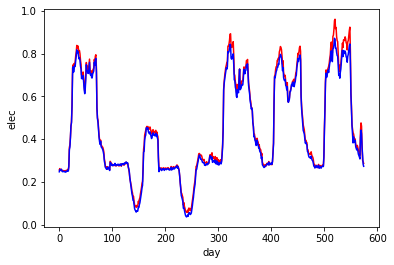

In [17]:
#예측값 불러오기
train_predict = sess.run(Y_pred, feed_dict={X: trainX})
test_predict = sess.run(Y_pred, feed_dict={X: testX})

plt.plot(testY,'r')
plt.plot(test_predict,'b')
plt.xlabel("day")
plt.ylabel("elec")
plt.show()

# --------------------------------------------------------------------------

# 전력+온도를 사용하여 예측

In [2]:
#http://mjgim.me/2017/08/02/LSTM.html

#라이브러리 불러오기
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

tf.set_random_seed(777)

C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [4]:
#데이터 불러오기
jan = pd.read_csv(r"C:/Users/jmlee/Desktop/4학년 2학기/딥러닝 전력 예측/전력 예측/생성data/1월.csv", header=None)
july = pd.read_csv(r"C:/Users/jmlee/Desktop/4학년 2학기/딥러닝 전력 예측/전력 예측/생성data/7월.csv", header=None)
jan_=jan.loc[:,[1,2,4,6]][1:]
# july_=july.loc[:,[1,2,4]][1:]

In [5]:
jan_

,1,2,4,6
1,1,1,238.32,-5
2,1,1,236.16,-5
3,1,1,237.24,-5
4,1,1,236.16,-5
5,1,1,234.72,-5
...,...,...,...,...
2876,1,30,340.2,1.8
2877,1,30,294.12,1.8
2878,1,30,263.88,1.8
2879,1,30,261,1.8


In [6]:
# All=pd.concat([jan_,july_])
#str을 float로 바꾸기
jan_.columns=['월','일','전력량','온도']
jan_[['월','일','전력량','온도']]=jan_[['월','일','전력량','온도']].apply(pd.to_numeric)

In [7]:
def MinMaxScaler(data):
    numerator=data-np.min(data,0)
    denominator=np.max(data,0)-np.min(data,0)
    return numerator/(denominator+1e-7)

In [8]:
#하이퍼 파라미터 설정
timesteps = seq_length = 7  #한개의 시퀀스길이(시계열데이터 입력갯수)
data_dim = 4  #variable개수
hidden_dim = 10  #각셀의 출력크기
output_dim = 1  #결과분류 총 수
learing_rate = 0.001   #학습률
iterations = 50_000   #에폭횟수

In [9]:
# #데이터 조절
# jan_["전력량"] /= 1e5

#Framework 제작
jan_['전력량']=MinMaxScaler(jan_['전력량'])
x = jan_[['월','일','전력량','온도']].values
y = jan_["전력량"].values  

In [10]:
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):  #seq_length=timesteps=6
    _x = np.copy(x[i:i + seq_length + 1])
#     _x[timesteps-2][data_dim-1] = 0
#     _x[timesteps-1][data_dim-1] = 0
#     _x[timesteps][data_dim-1] = 0
    _y = [y[i + seq_length]] #다음 전력(정답)
    dataX.append(_x)
    dataY.append(_y)

In [11]:
dataX

[array([[ 1.        ,  1.        ,  0.24716553, -5.        ],
        [ 1.        ,  1.        ,  0.24263039, -5.        ],
        [ 1.        ,  1.        ,  0.24489796, -5.        ],
        [ 1.        ,  1.        ,  0.24263039, -5.        ],
        [ 1.        ,  1.        ,  0.23960695, -5.        ],
        [ 1.        ,  1.        ,  0.23507181, -5.        ],
        [ 1.        ,  1.        ,  0.23507181, -5.        ],
        [ 1.        ,  1.        ,  0.2441421 , -5.        ]]),
 array([[ 1.        ,  1.        ,  0.24263039, -5.        ],
        [ 1.        ,  1.        ,  0.24489796, -5.        ],
        [ 1.        ,  1.        ,  0.24263039, -5.        ],
        [ 1.        ,  1.        ,  0.23960695, -5.        ],
        [ 1.        ,  1.        ,  0.23507181, -5.        ],
        [ 1.        ,  1.        ,  0.23507181, -5.        ],
        [ 1.        ,  1.        ,  0.2441421 , -5.        ],
        [ 1.        ,  1.        ,  0.24263039, -5.        ]]),
 arr

In [13]:
#학습데이터와 테스트데이터 분류

train_size = int(len(dataY) * 0.8)
test_size = len(dataY) - train_size 

trainX = np.array(dataX[:train_size])  #2298
testX = np.array(dataX[train_size : ])

trainY = np.array(dataY[:train_size])  #575
testY = np.array(dataY[train_size : ])

In [14]:
#LSTM모델 구축
#placeholder 초기화 후 텐서에 매핑
X = tf.placeholder(tf.float32, [None, seq_length+1, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

def lstm_cell(): #cell생성
    cell = tf.nn.rnn_cell.LSTMCell(hidden_dim, reuse=tf.AUTO_REUSE)  #출력의 크기를 hidden dim=4
    return cell 
## 5 layers for hidden layer
multi_cells = rnn.MultiRNNCell([lstm_cell() for _ in range(5)], state_is_tuple=True)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [15]:
# dynamic rnn 구조(RNN 신경망)연결
outputs, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32) #결과값 output차원은 hidden_dim의 크기와 동일

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [16]:
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)

# sum of the squares= 표준편차(예측값과 실제값의차이)
loss = tf.reduce_sum(tf.square(Y_pred - Y))  

In [17]:
#RMSprop 알고리즘
train = tf.train.RMSPropOptimizer(learing_rate).minimize(loss)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [19]:
for i in range(iterations):
    _  , cost = sess.run([train ,loss], feed_dict={X: trainX, Y: trainY})
    if (i+1) % (iterations/1000) == 0:
        print("[step: {}] loss: {}".format(i+1, cost))

[step: 50] loss: 113.8753662109375
[step: 100] loss: 38.01321029663086
[step: 150] loss: 30.45541763305664
[step: 200] loss: 28.467594146728516
[step: 250] loss: 27.262353897094727
[step: 300] loss: 26.29720687866211
[step: 350] loss: 25.355976104736328
[step: 400] loss: 24.339271545410156
[step: 450] loss: 23.178224563598633
[step: 500] loss: 21.83334732055664
[step: 550] loss: 20.279376983642578
[step: 600] loss: 18.35094451904297
[step: 650] loss: 16.094430923461914
[step: 700] loss: 13.90861988067627
[step: 750] loss: 12.191887855529785
[step: 800] loss: 10.932397842407227
[step: 850] loss: 9.955422401428223
[step: 900] loss: 9.108628273010254
[step: 950] loss: 8.402812004089355
[step: 1000] loss: 7.755821228027344
[step: 1050] loss: 7.197959899902344
[step: 1100] loss: 6.689811706542969
[step: 1150] loss: 6.200000286102295
[step: 1200] loss: 5.770071029663086
[step: 1250] loss: 5.325443267822266
[step: 1300] loss: 4.939764976501465
[step: 1350] loss: 4.586132049560547
[step: 1400]

[step: 10950] loss: 0.5421079397201538
[step: 11000] loss: 0.6235745549201965
[step: 11050] loss: 0.5558693408966064
[step: 11100] loss: 0.5443028211593628
[step: 11150] loss: 0.5831336975097656
[step: 11200] loss: 0.5952977538108826
[step: 11250] loss: 0.52823406457901
[step: 11300] loss: 0.6145062446594238
[step: 11350] loss: 0.5455136895179749
[step: 11400] loss: 0.5337052345275879
[step: 11450] loss: 0.5753230452537537
[step: 11500] loss: 0.5696967244148254
[step: 11550] loss: 0.5308859348297119
[step: 11600] loss: 0.5835336446762085
[step: 11650] loss: 0.5207818150520325
[step: 11700] loss: 0.5381980538368225
[step: 11750] loss: 0.580363929271698
[step: 11800] loss: 0.5093281269073486
[step: 11850] loss: 0.5925374031066895
[step: 11900] loss: 0.5172621607780457
[step: 11950] loss: 0.5197780132293701
[step: 12000] loss: 0.5708903074264526
[step: 12050] loss: 0.5008310079574585
[step: 12100] loss: 0.5797946453094482
[step: 12150] loss: 0.506056547164917
[step: 12200] loss: 0.5182110

[step: 21400] loss: 0.4143390357494354
[step: 21450] loss: 0.32058626413345337
[step: 21500] loss: 0.3632519543170929
[step: 21550] loss: 0.2737910747528076
[step: 21600] loss: 0.40174487233161926
[step: 21650] loss: 0.33633333444595337
[step: 21700] loss: 0.333450049161911
[step: 21750] loss: 0.2878566086292267
[step: 21800] loss: 0.3699186146259308
[step: 21850] loss: 0.36623433232307434
[step: 21900] loss: 0.3123113811016083
[step: 21950] loss: 0.3251495957374573
[step: 22000] loss: 0.33145323395729065
[step: 22050] loss: 0.3999498784542084
[step: 22100] loss: 0.2724519968032837
[step: 22150] loss: 0.36936724185943604
[step: 22200] loss: 0.3103790879249573
[step: 22250] loss: 0.4025097191333771
[step: 22300] loss: 0.2541028559207916
[step: 22350] loss: 0.40194764733314514
[step: 22400] loss: 0.3094259202480316
[step: 22450] loss: 0.3607296943664551
[step: 22500] loss: 0.2622409760951996
[step: 22550] loss: 0.37747445702552795
[step: 22600] loss: 0.3363572955131531
[step: 22650] loss

[step: 31800] loss: 0.22922882437705994
[step: 31850] loss: 0.21763868629932404
[step: 31900] loss: 0.2864491641521454
[step: 31950] loss: 0.30274060368537903
[step: 32000] loss: 0.2176489233970642
[step: 32050] loss: 0.22411303222179413
[step: 32100] loss: 0.22362111508846283
[step: 32150] loss: 0.296312153339386
[step: 32200] loss: 0.2957228720188141
[step: 32250] loss: 0.20414094626903534
[step: 32300] loss: 0.2270025908946991
[step: 32350] loss: 0.23165741562843323
[step: 32400] loss: 0.2898463010787964
[step: 32450] loss: 0.28188684582710266
[step: 32500] loss: 0.19756801426410675
[step: 32550] loss: 0.23582737147808075
[step: 32600] loss: 0.24254214763641357
[step: 32650] loss: 0.2786391079425812
[step: 32700] loss: 0.2679159641265869
[step: 32750] loss: 0.19627690315246582
[step: 32800] loss: 0.23791421949863434
[step: 32850] loss: 0.24807928502559662
[step: 32900] loss: 0.27249225974082947
[step: 32950] loss: 0.25719141960144043
[step: 33000] loss: 0.19405151903629303
[step: 33

[step: 42200] loss: 0.1949252337217331
[step: 42250] loss: 0.2322825938463211
[step: 42300] loss: 0.2170053869485855
[step: 42350] loss: 0.1741761565208435
[step: 42400] loss: 0.15450912714004517
[step: 42450] loss: 0.23317646980285645
[step: 42500] loss: 0.2355121225118637
[step: 42550] loss: 0.17607338726520538
[step: 42600] loss: 0.16223961114883423
[step: 42650] loss: 0.17523649334907532
[step: 42700] loss: 0.2627352178096771
[step: 42750] loss: 0.20379354059696198
[step: 42800] loss: 0.1476331204175949
[step: 42850] loss: 0.17629972100257874
[step: 42900] loss: 0.23029187321662903
[step: 42950] loss: 0.21046283841133118
[step: 43000] loss: 0.1662794053554535
[step: 43050] loss: 0.15882544219493866
[step: 43100] loss: 0.2431706041097641
[step: 43150] loss: 0.22895963490009308
[step: 43200] loss: 0.1558912694454193
[step: 43250] loss: 0.17271921038627625
[step: 43300] loss: 0.21103309094905853
[step: 43350] loss: 0.23552101850509644
[step: 43400] loss: 0.17746976017951965
[step: 434

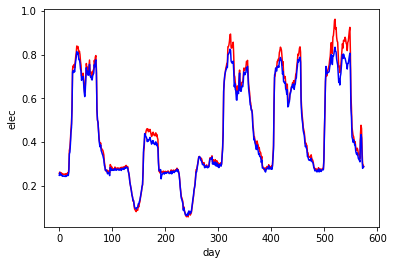

In [20]:
#예측값 불러오기
train_predict = sess.run(Y_pred, feed_dict={X: trainX})
test_predict = sess.run(Y_pred, feed_dict={X: testX})

plt.plot(testY,'r')
plt.plot(test_predict,'b')
plt.xlabel("day")
plt.ylabel("elec")
plt.show()